# Spatial data from Slide-seq

This tutorial uses data from: 

_Slide-seq: A scalable technology for measuring genome-wide expression at high spatial resolution_

  - Rodriques et al (Science 2019)
  - [https://doi.org/10.1126/science.aaw1219](https://doi.org/10.1126/science.aaw1219)


For this demo, you need the data files for Puck_180819_12

Taken from: https://portals.broadinstitute.org/single_cell/study/SCP354/slide-seq-study#study-summary

Specifically these two files:

- MappedDGEForR.csv
- BeadMapping_10-17_1014/BeadLocationsForR.csv

## Covered Here

- Computing Autocorrelation in Hotspot to identify spatial genes
- Computing local correlations between spatial genes to identify modules
- Plotting modules, correlations, and module scores

## Not Covered Here

- Data preprocessing (see Squidpy/Scanpy)

In [1]:
import sys

!pip install --quiet llvmlite --ignore-installed
!pip install --quiet --upgrade numba
!pip install hotspotsc
!pip install --quiet scanpy
!pip install --quiet mplscience

In [2]:
import scanpy as sc
import hotspot

import numpy as np
import mplscience
import matplotlib

In [3]:
url = "https://github.com/YosefLab/scVI-data/blob/master/rodriques_slideseq.h5ad?raw=true"
adata = sc.read("rodriques_slideseq.h5ad", backup_url=url)
adata.obs["total_counts"] = np.asarray(adata.X.sum(1)).ravel()
spatial_coords = adata.obsm['spatial']
adata.layers["csc_counts"] = adata.X.tocsc()

# renormalize the data for expression viz on plots
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## Creating Hotspot object

To start an analysis, first creat the hotspot object
When creating the object, you need to specify:

- The gene counts matrix
- Which background model to use
- The latent space we are using to compute our cell metric
  - Here we use the physical barcode positions
- The per-cell scaling factor
    - Here we use the number of umi per barcode
    
Once the object is created, the neighborhood graph must be computed with `create_knn_graph`

The two options that are specificied are `n_neighbors` which determines the size of the neighborhood, and `weighted_graph`.

Here we set `weighted_graph=False` to just use binary, 0-1 weights and `n_neighbors=300` to create a local neighborhood size of the nearest 300 barcodes.  Larger neighborhood sizes can result in more robust detection of correlations and autocorrelations at a cost of missing more fine-grained, smaller-scale, spatial patterns

In [4]:
# Create the Hotspot object and the neighborhood graph
hs = hotspot.Hotspot(
    adata,
    layer_key="csc_counts",
    model='bernoulli',
    latent_obsm_key="spatial",
    umi_counts_obs_key="total_counts",
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=300,
)

## Determining genes with spatial variation

Now we compute autocorrelations for each gene, using the spatial metric, to determine which genes have the most spatial variation.

In [5]:
hs_results = hs.compute_autocorrelations(jobs=6)

hs_results.head()

100%|██████████| 6942/6942 [02:05<00:00, 55.17it/s]


,C,Z,Pval,FDR
Gene,,,,
Ttr,0.198163,438.062553,0.0,0.0
Plp1,0.110854,246.179476,0.0,0.0
Enpp2,0.103074,211.241883,0.0,0.0
Fth1,0.092905,207.076346,0.0,0.0
Cartpt,0.087053,180.180112,0.0,0.0


## Grouping genes into spatial modules

To get a better idea of what spatial patterns exist, it is helpful to group the genes into modules.

Hotspot does this using the concept of "local correlations" - that is, <br> 
correlations that are computed between genes between cells in the same neighborhood.

Here we avoid running the calculation for all Genes x Genes pairs and instead <br> only run this on genes that have significant spatial autocorrelation to begin with.

The method `compute_local_correlations` returns a Genes x Genes matrix of <br>
Z-scores for the significance of the correlation between genes.  This object <br>
is also retained in the `hs` object and is used in the subsequent steps.

In [6]:
# Select the genes with significant spatial autocorrelation
hs_genes = hs_results.index[hs_results.FDR < 0.05]

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=8)

Computing pair-wise local correlation on 875 features...


100%|██████████| 382375/382375 [1:30:35<00:00, 70.35it/s]  


Now that pair-wise local correlations are calculated, we can group genes into modules.

To do this, a convenience method is included `create_modules` which performs <br> 
agglomerative clustering with two caveats:

- If the FDR-adjusted p-value of the correlation between two branches exceeds `fdr_threshold`, <br>
then the branches are not merged.
- If two branches are two be merged and they are both have at least `min_gene_threshold` genes, <br>
then the branches are not merged.  Further genes that would join to the resulting merged module <br> (and are therefore ambiguous) either remain unassigned (if `core_only=True`) or are assigned to the module with the <br>
smaller average correlations between genes, i.e. the least-dense module (if `core_only=False`)

The output is a Series that maps gene to module number.  Unassigned genes are indicated with a module number of `-1`

This method was used to preserved substructure (nested modules) while still giving the analyst <br>
some control. However, since there are a lot of ways to do hierarchical clustering, you can also <br>
manually cluster using the gene-distances in `hs.local_correlation_z`

In [7]:
modules = hs.create_modules(
    min_gene_threshold=20, core_only=False, fdr_threshold=0.05
)

modules.value_counts()

 4    243
-1    162
 3    117
 2    108
 1    101
 6     75
 5     69
Name: Module, dtype: int64

## Plotting module correlations

A convenience method is supplied to plot the results of `hs.create_modules`

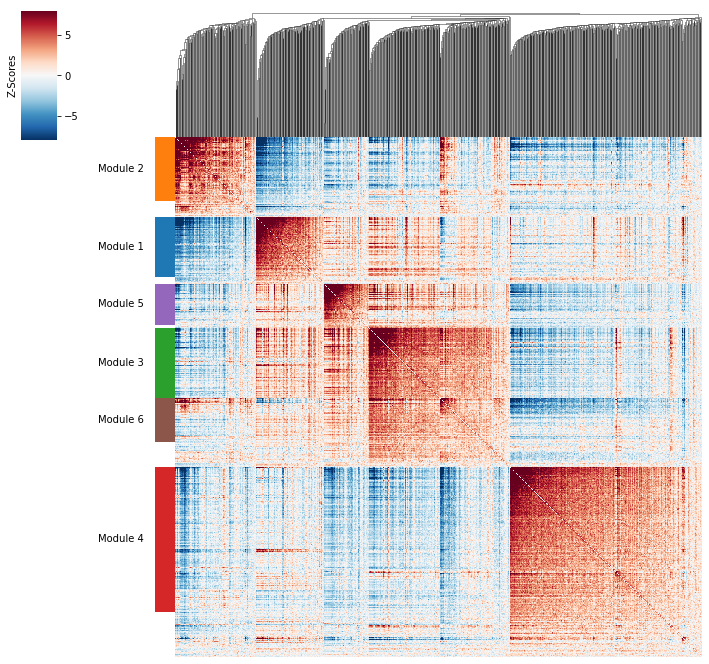

In [8]:
hs.plot_local_correlations()

To explore individual genes, we can look at the genes with the top *autocorrelation* <br>
in a given module as these are likely the most informative.

In [9]:
# Show the top genes for a module

module = 1

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]
results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
Plp1,0.110854,246.179476,0.000000e+00,0.000000e+00,1.0
Fth1,0.092905,207.076346,0.000000e+00,0.000000e+00,1.0
Mbp,0.059088,130.720260,0.000000e+00,0.000000e+00,1.0
Apod,0.026268,57.079574,0.000000e+00,0.000000e+00,1.0
Mobp,0.022971,50.674939,0.000000e+00,0.000000e+00,1.0
Mal,0.019166,41.899011,0.000000e+00,0.000000e+00,1.0
Trf,0.014862,32.176320,1.892509e-227,3.550755e-225,1.0
Car2,0.012635,27.513802,6.002172e-167,9.920732e-165,1.0
Cryab,0.011001,23.612023,1.450162e-123,1.973927e-121,1.0


To get an idea of what spatial pattern the module is referencing, we can plot the top module genes’ expression onto the spatial positions


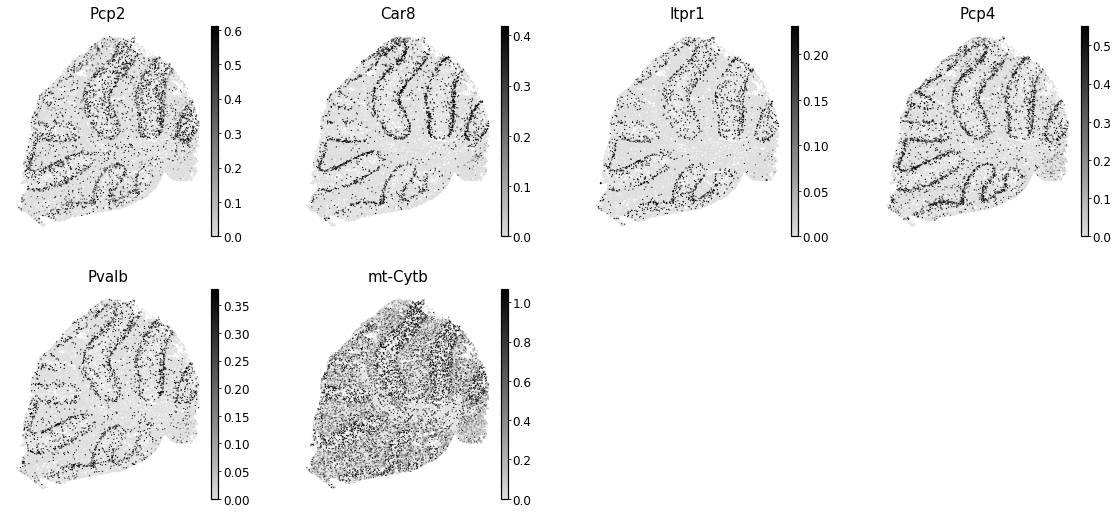

In [19]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('grays', ['#DDDDDD', '#000000'])

module = 2
results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]
genes = results.sort_values('Z', ascending=False).head(6).index.tolist()

adata.obsm['spatial'] = spatial_coords.values

with mplscience.style_context():
    sc.pl.spatial(
        adata, 
        color=genes,
        cmap=cmap,
        frameon=False,
        vmin='p0',
        vmax='p95',
        spot_size=30
    )    

## Summary Module Scores

To aid in the recognition of the general behavior of a module, Hotspot can compute <br>
aggregate module scores.

In [20]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 6 modules...


100%|██████████| 6/6 [01:37<00:00, 16.33s/it]


,1,2,3,4,5,6
barcodes,,,,,,
CGTACAATTTTTTT,-0.421503,0.829196,-0.025306,-0.403850,-0.209946,0.058708
TTCGTTATTTTTTT,-0.433274,1.194746,-0.251114,-0.451754,-0.206385,0.263886
CAAACCAACCCCCC,-0.302593,0.609414,-0.171035,0.265985,-0.315975,0.350375
TCTTTTCACCCCCC,-0.510236,1.309481,-0.082019,-0.743183,-0.100390,0.198135
GGATTGAACCCCCC,-0.554569,0.108010,-0.132590,-0.338540,-0.142225,0.255825


In [122]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

Here we can visualize these module scores by plotting them over the barcode positions:

In [123]:
with mplscience.style_context():
    sc.pl.spatial(adata, color=module_cols, frameon=False, vmin="p0", vmax="p99", spot_size=30)

TypeError: '(slice(None, None, None), (0, 1))' is an invalid key

<Figure size 1391.04x576 with 0 Axes>